In [1]:
# Imports
import sqlite3
import pandas as pd

In [2]:
# Use pandas to read the data files

users = pd.read_csv('u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
movies = pd.read_csv('movies.csv', sep=',', names=['movie_id', 'title', 'genres'])
ratings = pd.read_csv('ratings.csv', sep=',', names=['user_id', 'movie_id', 'rating', 'timestamp'])

In [3]:
# Remove any rows where conversion to integer is not possible
users = users[pd.to_numeric(users['user_id'], errors='coerce').notnull()]
movies = movies[pd.to_numeric(movies['movie_id'], errors='coerce').notnull()]
ratings = ratings[pd.to_numeric(ratings['user_id'], errors='coerce').notnull() & pd.to_numeric(ratings['movie_id'], errors='coerce').notnull()]

# Remove duplicates in unique identifiers
users = users.drop_duplicates(subset=['user_id'])
movies = movies.drop_duplicates(subset=['movie_id'])
ratings = ratings.drop_duplicates(subset=['user_id', 'movie_id'])

# Ensure correct data types
users = users.astype({'user_id': 'int32', 'gender': 'str', 'age': 'int32', 'occupation': 'str', 'zip_code': 'str'})
movies = movies.astype({'movie_id': 'int32', 'title': 'str', 'genres': 'str'})
ratings = ratings.astype({'user_id': 'int32', 'movie_id': 'int32', 'rating': 'float32', 'timestamp': 'int64'})

In [7]:
# Connect to SQLite database
conn = sqlite3.connect('movies.db')
cursor = conn.cursor()

# Create tables if they do not exist
cursor.execute('''
CREATE TABLE IF NOT EXISTS users (
    user_id INTEGER PRIMARY KEY,
    gender TEXT,
    age INTEGER,
    occupation TEXT,
    zip_code TEXT
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS movies (
    movie_id INTEGER PRIMARY KEY,
    title TEXT,
    genres TEXT
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS ratings (
    user_id INTEGER,
    movie_id INTEGER,
    rating FLOAT,
    timestamp INTEGER,
    PRIMARY KEY (user_id, movie_id),
    FOREIGN KEY (user_id) REFERENCES users(user_id),
    FOREIGN KEY (movie_id) REFERENCES movies(movie_id)
)
''')

# Check for duplicates before inserting into the database
existing_users = pd.read_sql_query("SELECT user_id FROM users", conn)
users_to_insert = users[~users['user_id'].isin(existing_users['user_id'])]

existing_movies = pd.read_sql_query("SELECT movie_id FROM movies", conn)
movies_to_insert = movies[~movies['movie_id'].isin(existing_movies['movie_id'])]

existing_ratings = pd.read_sql_query("SELECT user_id, movie_id FROM ratings", conn)
ratings_to_insert = ratings[~ratings.set_index(['user_id', 'movie_id']).index.isin(existing_ratings.set_index(['user_id', 'movie_id']).index)]

# Insert data into the database
users_to_insert.to_sql('users', conn, if_exists='append', index=False)
movies_to_insert.to_sql('movies', conn, if_exists='append', index=False)
ratings_to_insert.to_sql('ratings', conn, if_exists='append', index=False)

conn.commit()
# conn.close()


SQL Queries fro recommendations

In [8]:
query = '''
SELECT movies.title, AVG(ratings.rating) as avg_rating
FROM ratings
JOIN movies ON ratings.movie_id = movies.movie_id
GROUP BY movies.movie_id
ORDER BY avg_rating DESC
LIMIT 10
'''
top_movies = pd.read_sql_query(query, conn)
print(top_movies)


                                              title  avg_rating
0                  Won't You Be My Neighbor? (2018)         5.0
1                           De platte jungle (1978)         5.0
2                             Blue Planet II (2017)         5.0
3                             Loving Vincent (2017)         5.0
4                                      Black Mirror         5.0
5                      Bobik Visiting Barbos (1977)         5.0
6        In the blue sea, in the white foam. (1984)         5.0
7  On the Trail of the Bremen Town Musicians (1973)         5.0
8                         Gena the Crocodile (1969)         5.0
9                                  Obsession (1965)         5.0


In [9]:
# Recommend movies based on user preferences
user_id = 1  # Replace with the target user ID
query = '''
SELECT m.title, AVG(r.rating) as avg_rating
FROM ratings r
JOIN movies m ON r.movie_id = m.movie_id
WHERE r.user_id = ?
GROUP BY r.movie_id
ORDER BY avg_rating DESC
LIMIT 10
'''
user_recommendations = pd.read_sql_query(query, conn, params=(user_id,))
print(user_recommendations)


                                       title  avg_rating
0                Seven (a.k.a. Se7en) (1995)         5.0
1                 Usual Suspects, The (1995)         5.0
2                       Bottle Rocket (1996)         5.0
3                             Rob Roy (1995)         5.0
4                      Canadian Bacon (1995)         5.0
5                           Desperado (1995)         5.0
6                       Billy Madison (1995)         5.0
7     Dumb & Dumber (Dumb and Dumber) (1994)         5.0
8  Star Wars: Episode IV - A New Hope (1977)         5.0
9                           Tommy Boy (1995)         5.0


In [10]:
# Find similar users and recommend movies they liked
user_id = 1  # Replace with the target user ID
query = '''
WITH similar_users AS (
    SELECT r2.user_id
    FROM ratings r1
    JOIN ratings r2 ON r1.movie_id = r2.movie_id
    WHERE r1.user_id = ?
    GROUP BY r2.user_id
    ORDER BY COUNT(r2.movie_id) DESC
    LIMIT 10
)
SELECT m.title, AVG(r.rating) as avg_rating
FROM ratings r
JOIN movies m ON r.movie_id = m.movie_id
WHERE r.user_id IN (SELECT user_id FROM similar_users)
GROUP BY r.movie_id
ORDER BY avg_rating DESC
LIMIT 10
'''
similar_user_recommendations = pd.read_sql_query(query, conn, params=(user_id,))
print(similar_user_recommendations)


                                               title  avg_rating
0                            Band of Brothers (2001)         5.0
1                                        Seve (2014)         5.0
2                                    Brooklyn (2015)         5.0
3                      She's Out of My League (2010)         5.0
4                             Ugly Truth, The (2009)         5.0
5                             Strictly Sexual (2008)         5.0
6  Sophie Scholl: The Final Days (Sophie Scholl -...         5.0
7                            After the Sunset (2004)         5.0
8                                Safety Last! (1923)         5.0
9                                  Adam's Rib (1949)         5.0


Visualization of top Movies

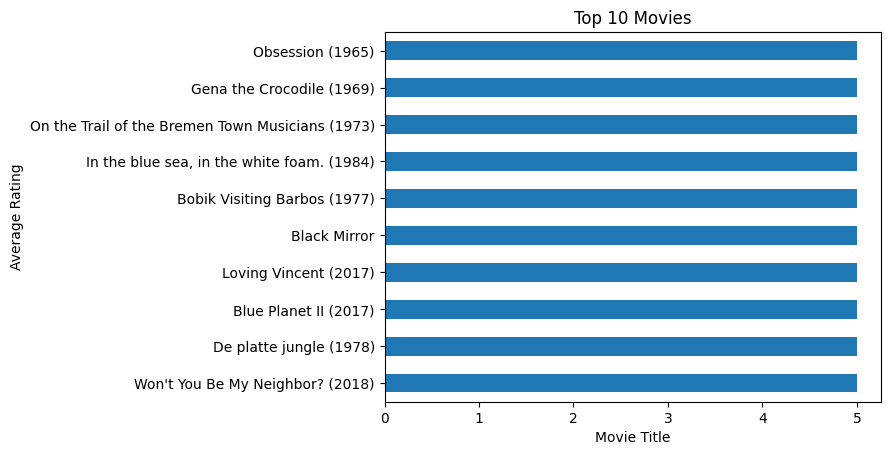

In [13]:
import matplotlib.pyplot as plt

top_movies.plot(kind='barh', x='title', y='avg_rating', legend=False)
plt.xlabel('Movie Title')
plt.ylabel('Average Rating')
plt.title('Top 10 Movies')
plt.show()
